# code2vec using Embeddings and NN

We are going to represent programs as token vectors and learn their representations using embeddings

We are going to create a prediction problem and try to predict whether the program submitted with be considered as correct, i.e. the program pass the testcases specified by the lecturer. Creating a prediction problem to learn representations of the data is a useful approach. There is no easy way to represent these programs so we are going to learn these representations. 
 

* https://code.google.com/archive/p/word2vec/

* https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-pre-trained-glove-word-embeddings-part-3-53fcea9a17fa

* https://www.cse.iitb.ac.in/~pb/papers/bionlp-acl17-medical-coding.pdf

* https://github.com/sloomba/protein2vec

* https://github.com/samiroid/usr2vec

* https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py

* http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/

* Topic Modelling for Humans: https://radimrehurek.com/gensim/

* https://spacy.io/models/

* https://www.shanelynn.ie/get-busy-with-word-embeddings-introduction/

* Code2Vec https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8031179&tag=1, https://arxiv.org/pdf/1803.09473.pdf, https://code2vec.org/

* From People2Vec to Emotional AI: http://people2vec.org/

* Using Word2vec for Music Recommendations: https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484

* Source code identifier embeddings: https://blog.sourced.tech/post/id2vec/

* Recommending Recommendation Systems: https://gab41.lab41.org/recommending-recommendation-systems-cc39ace3f5c1, https://github.com/Lab41/Misc/blob/master/blog/python2vec/Python2Vec%20Example.ipynb

* Python2Vec: Word Embeddings for Source Code: https://gab41.lab41.org/python2vec-word-embeddings-for-source-code-3d14d030fe8f

* Anything2Vec: https://gab41.lab41.org/anything2vec-e99ec0dc186

* AutoKeras: https://towardsdatascience.com/autokeras-the-killer-of-googles-automl-9e84c552a319, https://autokeras.com/

* Learning Program Embeddings to Propagate Feedback on Student Code: https://web.stanford.edu/~cpiech/bio/papers/programEncoding.pdf, https://github.com/chrispiech/refactoredEncoder

* Research at Code.org: https://code.org/research

* Cheatsheet: https://startupsventurecapital.com/essential-cheat-sheets-for-machine-learning-and-deep-learning-researchers-efb6a8ebd2e5

* DCU Deep Learning Summer School: https://telecombcn-dl.github.io/2018-dlcv/, https://www.slideshare.net/xavigiro/d1l2-the-neural-network-zoo-upc-2018-deep-learning-for-computer-vision

* Embeddings: https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
font = {'weight': 'bold', 'size': 20}
plt.rc('font', **font)

## VECTORIZE

**Programming data**: Student develop programs locally for the laboratory sheets of computer programming courses at our university. These programs are submitted by them to an automatic grading platform that runs some test cases specified by the lecturer on each program. A JSON output for those testcases and whether the program passed them or not along with the actual code is stored.

In [3]:
!ls data/raw/programming_data.json

data/raw/programming_data.json


In [4]:
dataframe = pd.read_json('data/raw/programming_data.json')

In [5]:
dataframe.head(2)

,academic_year_0,academic_year_1,correct,date,extension,ip,module,task,upload,user
0,2016,2017,True,2016-09-19 14:11:41,py,,ca277,add.py,#!/usr/bin/env python\n\na = int(raw_input())\...,b9e7e608-6036-4d44-8770-a7036176b53c
1,2016,2017,True,2016-09-19 14:17:33,py,,ca277,concat-lines.py,#!/usr/bin/env python\n\na = str(raw_input())\...,b9e7e608-6036-4d44-8770-a7036176b53c


In [6]:
'{:,}'.format(len(dataframe))

'591,707'

Grab only code submissions from Python modules:

In [7]:
PYTHON_MODULES = [
    'ca116', 
    'ca117', 
    'ca177', 
    'ca277', 
    'ca278',
]

In [8]:
dataframe = dataframe[dataframe['module'].isin(PYTHON_MODULES)]

In [9]:
'{:,}'.format(len(dataframe))

'490,820'

Target value:

In [10]:
dataframe.correct.value_counts()

False    296369
True     194451
Name: correct, dtype: int64

Remove comments:

In [11]:
import re
def remove_comments(text):
    return re.sub(re.compile('#.*?\n'), '', text)

Grab docs (code submissions) and labels (correct or not):

In [12]:
def get_docs_and_labels(df):
    _docs = []
    _labels = []
    for index in df.index:
        # Program
        code = remove_comments(
            df.at[index, 'upload']
        )
        _docs.append(code)
        # Label
        label = int(df.at[index, 'correct'])
        _labels.append(label)
    return _docs, _labels

In [13]:
docs, labels = get_docs_and_labels(dataframe)

In [14]:
'{:,}'.format(len(docs))

'490,820'

In [15]:
docs[0]

u'\na = int(raw_input())\nb = int(raw_input())\n\nprint a + b\n\n\n'

In [16]:
labels[0]

1

## 1) Programs as word vectors

https://faroit.github.io/keras-docs/1.2.2/preprocessing/text/

In [17]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [18]:
NUM_WORDS = 2000 # Originally 231,659 words

In [19]:
def get_tokenizer():

    return Tokenizer(num_words=NUM_WORDS, 
                     filters='\t\n', 
                     lower=True, 
                     split=' ', 
                     char_level=False)

In [20]:
word_t = get_tokenizer()

In [21]:
word_t.fit_on_texts(docs)

In [22]:
# word_counts: a dictionary of words and their counts.
word_t.word_counts['if'] # word count

552539

In [23]:
# document_count: an integer count of the total number of documents that were used to fit the Tokenizer.
'Number docs: {:,}'.format(word_t.document_count)

'Number docs: 490,820'

In [24]:
# word_index: a dictionary of words and their uniquely assigned integers.
word_t.word_index['if'] # index

4

In [25]:
# word_docs: a dictionary of words and how many documents each appeared in.
word_t.word_docs['if']

298487

In [27]:
sequences = word_t.texts_to_sequences(docs)

In [28]:
sequences[0]

[17, 1, 358, 50, 1, 358, 6, 17, 3, 50]

Look at the lenght of these sequences:

In [29]:
len_seqs = [len(s) for s in sequences]

In [30]:
np.mean(len_seqs), np.std(len_seqs), np.max(len_seqs)

(38.591420480013042, 38.577314137088699, 2358)

In [31]:
MAX_LENGTH = 50

Dictionary to transform a vector back to the program:

In [32]:
id_to_word = { v: k for k, v in word_t.word_index.items() }

In [33]:
id_to_word[1]

u'='

In [34]:
[id_to_word[index] for index in sequences[0]]

[u'a',
 u'=',
 u'int(raw_input())',
 u'b',
 u'=',
 u'int(raw_input())',
 u'print',
 u'a',
 u'+',
 u'b']

Pad documents:

In [35]:
from keras.preprocessing.sequence import pad_sequences

In [36]:
# pad documents
padded_docs = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

In [37]:
padded_docs[0]

array([ 17,   1, 358,  50,   1, 358,   6,  17,   3,  50,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

Model:

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [47]:
from keras import backend as K

def f1(y_true, y_pred):
    
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [57]:
def get_model():

    # define the model
    model = Sequential()
    model.add(Embedding(NUM_WORDS, 100, input_length=MAX_LENGTH))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['acc', f1])
    # summarize the model
    print(model.summary())
    return model

In [58]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5001      
Total params: 205,001
Trainable params: 205,001
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
from sklearn.model_selection import train_test_split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.2, random_state=0)

In [61]:
# fit the model
# model.fit(padded_docs, labels, epochs=2, verbose=1)

model.fit(X_train, 
          y_train,
          epochs=10,
          validation_split=0.2)

Train on 314124 samples, validate on 78532 samples
Epoch 1/10
314124/314124 [==============================] - 58s 186us/step - loss: 0.5925 - acc: 0.6797 - f1: 0.5009 - val_loss: 0.5660 - val_acc: 0.7038 - val_f1: 0.5799
Epoch 2/10
314124/314124 [==============================] - 58s 185us/step - loss: 0.5347 - acc: 0.7256 - f1: 0.6145 - val_loss: 0.5557 - val_acc: 0.7095 - val_f1: 0.5807
Epoch 3/10
314124/314124 [==============================] - 59s 187us/step - loss: 0.5113 - acc: 0.7420 - f1: 0.6438 - val_loss: 0.5573 - val_acc: 0.7150 - val_f1: 0.5757
Epoch 4/10
314124/314124 [==============================] - 589s 2ms/step - loss: 0.4970 - acc: 0.7509 - f1: 0.6596 - val_loss: 0.5526 - val_acc: 0.7190 - val_f1: 0.5928
Epoch 5/10
314124/314124 [==============================] - 58s 186us/step - loss: 0.4868 - acc: 0.7582 - f1: 0.6710 - val_loss: 0.5529 - val_acc: 0.7244 - val_f1: 0.6251
Epoch 6/10
314124/314124 [==============================] - 59s 189us/step - loss: 0.4793 - acc

In [62]:
# evaluate the model
word_loss, word_accuracy, word_f1 = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f, F1: %f' % (word_accuracy * 100, word_f1 * 100))

98164/98164 [==============================] - 4s 44us/step
Accuracy: 73.248849, F1: 64.109335


In [63]:
word_score = {
    'accuracy': word_accuracy,
    'F1': word_f1,
}
embeddings_scores = { 'Word': word_score }

In [64]:
def get_embeddings(model):

    # Embedding Layer
    embedding_layer = model.layers[0]
    embeddings = embedding_layer.get_weights()[0]
    print 'Embedding Layer shape:', embeddings.shape
    
    return embeddings

In [65]:
embeddings = get_embeddings(model)

Embedding Layer shape: (2000, 100)


In [66]:
embeddings[0]

array([-0.0002703 , -0.02028703, -0.02261768,  0.0228202 , -0.01892408,
       -0.01533403,  0.03816184,  0.01083327,  0.01291173,  0.01390106,
       -0.01929445,  0.01245635, -0.01950408, -0.00285929,  0.00441168,
       -0.01203742, -0.00051851, -0.0007111 ,  0.00874287,  0.0050099 ,
       -0.00264154,  0.00644676, -0.00749543,  0.01290755, -0.00162339,
        0.00932319, -0.01874615, -0.00491848,  0.00082686, -0.00422437,
        0.00016597,  0.01962766,  0.00880893,  0.05274449, -0.0158693 ,
        0.01371357,  0.0353712 , -0.00428436, -0.03806661, -0.01819082,
       -0.01822764, -0.00397752, -0.0105728 ,  0.01799194, -0.01581701,
       -0.00648104, -0.01479556,  0.00472498,  0.00229366, -0.01438559,
       -0.02122541, -0.010853  ,  0.00981577,  0.02842358,  0.01343832,
        0.01597697,  0.00683736, -0.01073337,  0.01445546,  0.01008323,
       -0.00385681, -0.01900307,  0.0065881 ,  0.00958926,  0.00908761,
       -0.00433705, -0.02886911, -0.00589604,  0.02263533,  0.00

In [67]:
# np.save('data/processed/word_embeddings', embeddings)

In [68]:
from sklearn.decomposition import PCA

def get_pca(embeddings):

    # PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(embeddings)
    print 'PCA explained variance ratio:', pca.explained_variance_ratio_, 'Total:', sum(pca.explained_variance_ratio_)
    return principal_components

In [69]:
pca = get_pca(embeddings)

PCA explained variance ratio: [ 0.11852997  0.04994293] Total: 0.168472900987


In [70]:
def get_top_words(tokenizer, N=50):
    
    return [word for word, occurrences in sorted(tokenizer.word_counts.items(), key=lambda t: t[1], reverse=True)[:N]]

In [71]:
top_words = get_top_words(word_t)

In [72]:
def plot_embeddings(low_dim_embs, id_to_word, top_words, figsize=(8, 8)):

    plt.figure(figsize=figsize, dpi=100)
    ax = plt.axes()
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_locator(plt.NullLocator())
    i = 0
    while i < len(low_dim_embs):

        if i in id_to_word:
            
            x, y = low_dim_embs[i, :]
            word = id_to_word[i]

            if word in top_words:
                plt.scatter(x, y, color='b')
                plt.annotate(word,
                            xy=(x, y),
                            xytext=(5, 2),
                            textcoords='offset points',
                            ha='right',
                            va='bottom',
                            fontsize=14)
        
        i += 1

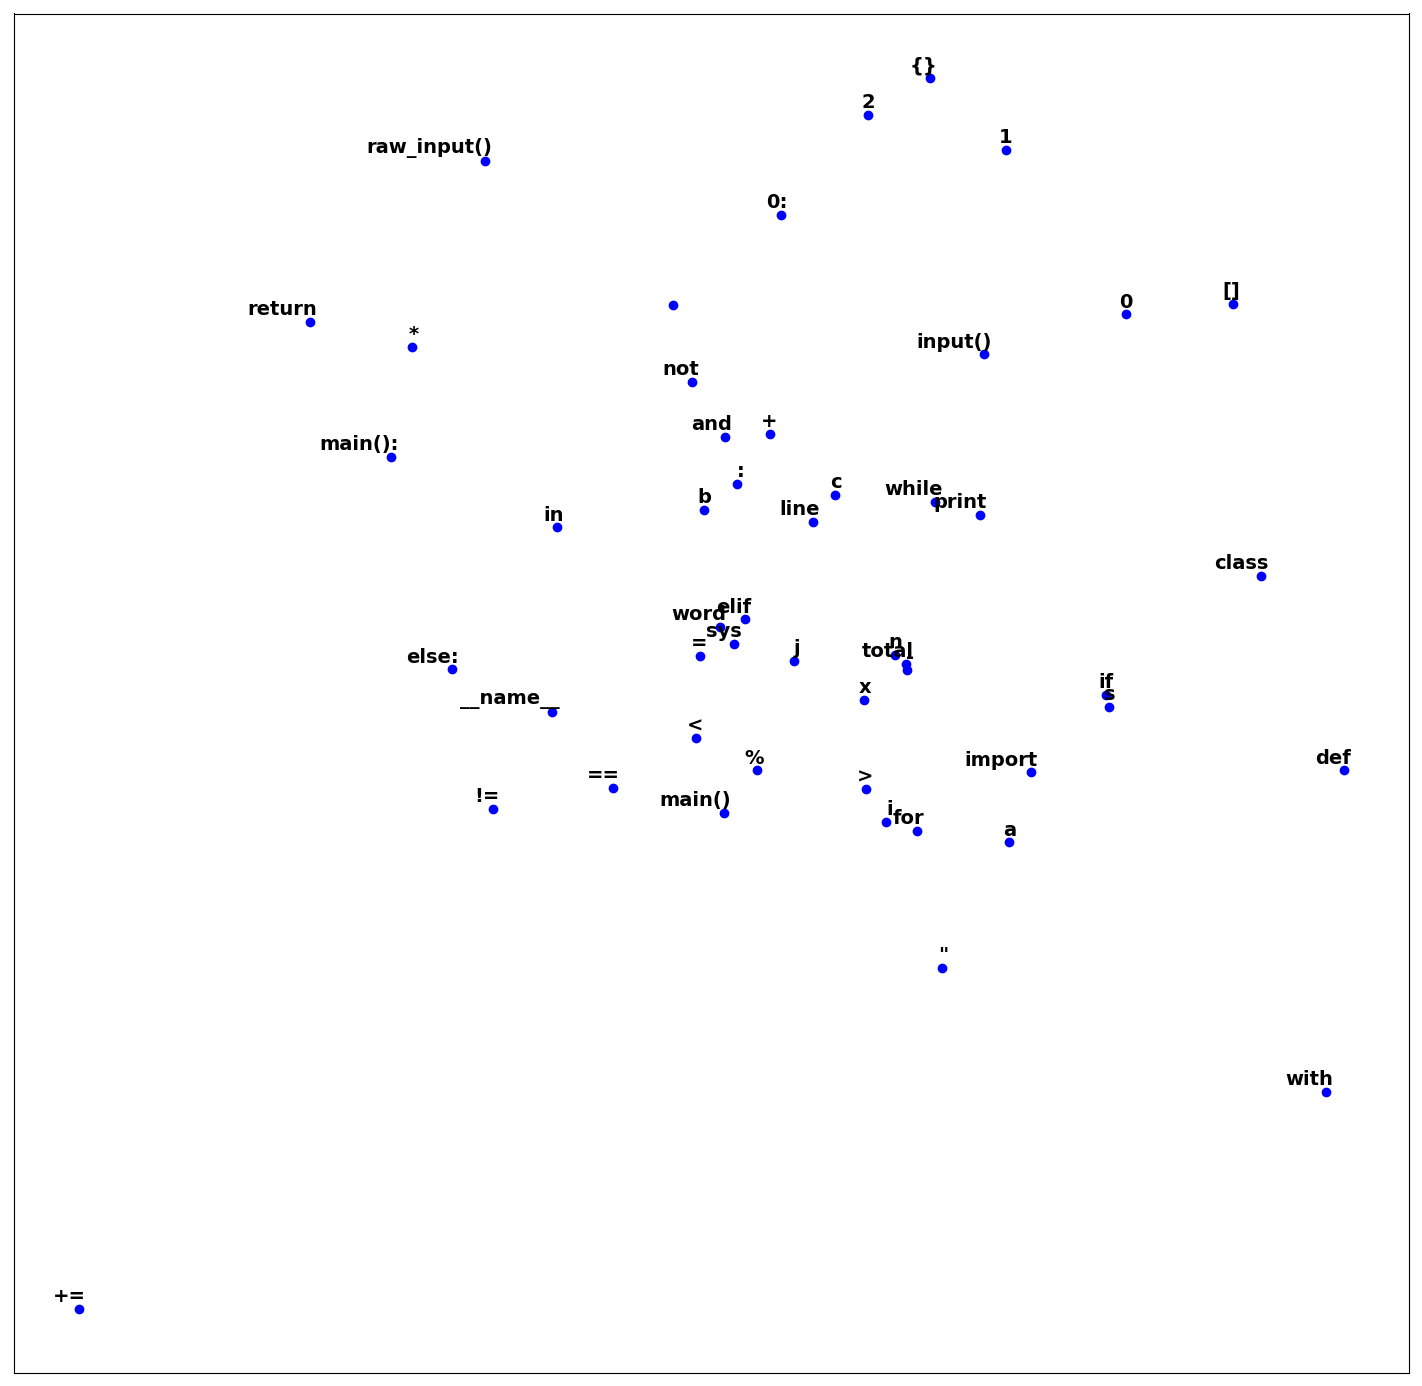

In [73]:
plot_embeddings(pca, id_to_word, top_words, figsize=(18, 18))

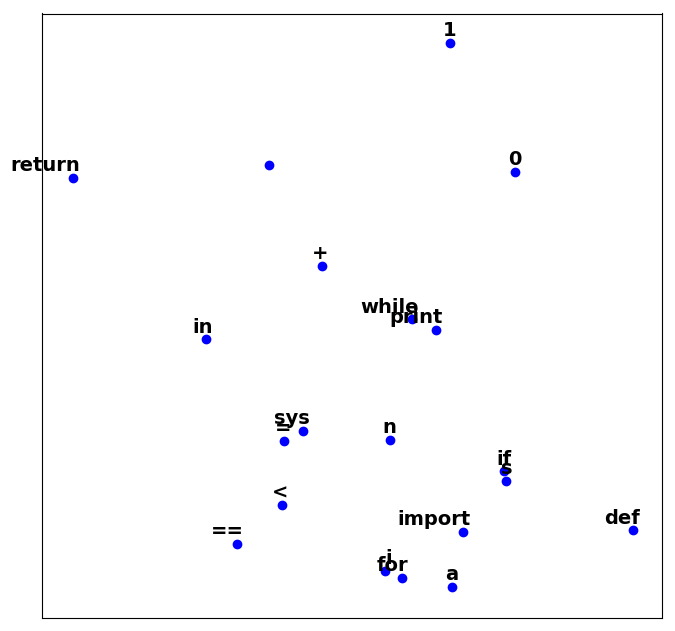

In [74]:
plot_embeddings(pca, id_to_word, get_top_words(word_t, 20))

Measure the distance between vectors:

In [75]:
from scipy.spatial.distance import euclidean, cosine

def get_vector_distance(embeddings, tok, word1, word2):
    
    return euclidean(embeddings[tok.word_index[word1]], 
                     embeddings[tok.word_index[word2]])
    
def get_vector_cosine_distance(embeddings, tok, word1, word2):
    
    return cosine(embeddings[tok.word_index[word1]], 
                  embeddings[tok.word_index[word2]])

Cosine similarity:

In [76]:
get_vector_cosine_distance(embeddings, word_t, '<', '>')

0.92414571880089835

In [77]:
get_vector_cosine_distance(embeddings, word_t, 'elif', 'else:')

0.9435312406626376

In [78]:
get_vector_cosine_distance(embeddings, word_t, '+', '-')

0.88456141482856976

In [224]:
get_vector_cosine_distance(embeddings, word_t, '(', ')')

0.91360234699101939

In [225]:
get_vector_cosine_distance(embeddings, word_t, '[', ']')

0.979229788224945

In [226]:
get_vector_cosine_distance(embeddings, word_t, 'if', 'else')

0.68487485100614776

In [227]:
get_vector_cosine_distance(embeddings, word_t, 'elif', 'else')

1.0735195755014035

In [228]:
get_vector_cosine_distance(embeddings, word_t, 'if', 'elif')

0.97326813616495045

In [229]:
get_vector_cosine_distance(embeddings, word_t, '}', ']')

0.88568378597547437

In [230]:
get_vector_cosine_distance(embeddings, word_t, '{', '[')

1.1822210022121307

Euclidean distance:

In [79]:
get_vector_distance(embeddings, word_t, '<', '>')

1.3719608783721924

In [80]:
get_vector_distance(embeddings, word_t, '==', '!=')

1.3409624099731445

In [81]:
get_vector_distance(embeddings, word_t, 'if', 'elif')

1.2262580394744873

In [82]:
get_vector_distance(embeddings, word_t, 'elif', 'else:')

1.2601438760757446

In [83]:
get_vector_distance(embeddings, word_t, '+', '-')

1.295180082321167

In [84]:
get_vector_distance(embeddings, word_t, 'for', 'while')

1.246814489364624

In [85]:
get_vector_distance(embeddings, word_t, 'def', 'import')

1.0941377878189087

In [86]:
def get_neighbors(word, emb, tok, id_to_item, top_n=5):

    dist = {}
    i = 0
    while i < len(emb):

        if i in id_to_item:
            w = id_to_item[i]
            if w != word:
                dist[w] = get_vector_cosine_distance(emb, tok, word, w)
        
        i += 1

    for key, value in sorted(dist.iteritems(), key=lambda (k,v): (v,k), reverse=True)[:top_n]:
        print "%s: %s" % (key, value)

In [87]:
get_neighbors('if', embeddings, word_t, id_to_word)

print("insufficient: 1.52704280768
world.\n"): 1.51390811269
self.tid: 1.51367161469
60: 1.50495967003
product: 1.47443927989


In [88]:
get_neighbors('+', embeddings, word_t, id_to_word)

has_access(self,: 1.47624565182
int(a[i]): 1.46347701144
"second: 1.44685963991
neg,: 1.44645168633
good: 1.44191358578


In [89]:
get_neighbors('for', embeddings, word_t, id_to_word)

len(sys.argv):: 1.45206182292
'6',: 1.43055473479
: 1.42782318718
(other.y-self.y)**2)**0.5: 1.40851274913
nd: 1.3960969415


In [90]:
get_neighbors('1', embeddings, word_t, id_to_word)

f1: 1.51956247114
print('insufficient: 1.51131176254
radius):: 1.48729861409
firstname: 1.46758685663
"5":: 1.46254252608


In [91]:
get_neighbors('def', embeddings, word_t, id_to_word)

print("insufficient: 1.64250782936
world.\n"): 1.5978234935
goals=0,: 1.58450300778
__len__(self):: 1.56995006831
return: 1.56883916501


## 2) Programs as tokens

In [151]:
from tokenize import generate_tokens
from StringIO import StringIO

In [152]:
token_ids = []
token_words = []
token_labels = []
i = 0
while i < len(docs):
    doc = docs[i]
    label = labels[i]
    try:
        tokens = [(t[0], t[1]) for t in list(generate_tokens(StringIO(doc).readline))]
        # Token ID
        token_ids.append(
            [token[0] for token in tokens]
        )
        # Token
        token_words.append(
            [token[1] for token in tokens]
        )
        token_labels.append(
            label
        )
    except:
        pass
    i += 1

### 2.1) Token words

In [153]:
'Number encoded docs: {:,}'.format(len(token_words))

'Number encoded docs: 472,087'

In [154]:
token_docs = [
    ' '.join(array) for array in token_words
]

In [155]:
token_t = get_tokenizer()

token_t.fit_on_texts(token_docs)

In [157]:
token_sequences = token_t.texts_to_sequences(token_docs)

id_to_token = { v: k for k, v in token_t.word_index.items() }

token_padded_docs = pad_sequences(token_sequences, maxlen=MAX_LENGTH, padding='post')

In [158]:
X_train, X_test, y_train, y_test = train_test_split(token_padded_docs, token_labels, test_size=0.2, random_state=0)

In [159]:
token_model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
flatten_9 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5001      
Total params: 205,001
Trainable params: 205,001
Non-trainable params: 0
_________________________________________________________________
None


In [160]:
token_model.fit(X_train, 
                y_train,
                epochs=10,
                validation_split=0.2)

Train on 302135 samples, validate on 75534 samples
Epoch 1/10
302135/302135 [==============================] - 57s 187us/step - loss: 0.5791 - acc: 0.6928 - f1: 0.5494 - val_loss: 0.5473 - val_acc: 0.7180 - val_f1: 0.6024
Epoch 2/10
302135/302135 [==============================] - 60s 200us/step - loss: 0.5185 - acc: 0.7385 - f1: 0.6507 - val_loss: 0.5322 - val_acc: 0.7330 - val_f1: 0.6432
Epoch 3/10
302135/302135 [==============================] - 61s 201us/step - loss: 0.4954 - acc: 0.7545 - f1: 0.6769 - val_loss: 0.5316 - val_acc: 0.7369 - val_f1: 0.6802
Epoch 4/10
302135/302135 [==============================] - 61s 202us/step - loss: 0.4819 - acc: 0.7628 - f1: 0.6899 - val_loss: 0.5258 - val_acc: 0.7403 - val_f1: 0.6550
Epoch 5/10
302135/302135 [==============================] - 62s 206us/step - loss: 0.4721 - acc: 0.7694 - f1: 0.7003 - val_loss: 0.5261 - val_acc: 0.7437 - val_f1: 0.6584
Epoch 6/10
302135/302135 [==============================] - 62s 204us/step - loss: 0.4654 - ac

In [161]:
token_loss, token_accuracy, token_f1 = token_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f, F1: %f' % (token_accuracy * 100, token_f1 * 100))

94418/94418 [==============================] - 5s 54us/step
Accuracy: 74.930628, F1: 67.186247


In [162]:
token_score = {
    'accuracy': token_accuracy,
    'F1': token_f1,
}
embeddings_scores['Word Token'] = token_score

In [163]:
token_embeddings = get_embeddings(token_model)

token_embeddings[0]

Embedding Layer shape: (2000, 100)


array([ 0.00072479, -0.02052157,  0.50440717, -0.00903519,  0.04234074,
        0.12038743, -0.02207636, -0.00696837, -0.00130028, -0.01148118,
       -0.0078795 ,  0.02692166,  0.00568148, -0.02150124, -0.03917861,
       -0.02477813, -0.00632054,  0.03963936, -0.03346051,  0.0483523 ,
        0.01883694, -0.01435367, -0.02609761,  0.03500605, -0.02925364,
       -0.08767537,  0.02706289, -0.02316153,  0.2480056 , -0.04850652,
       -0.08744363,  0.05964858, -0.03151005,  0.01287291, -0.02764473,
        0.04258429,  0.01432234,  0.00060787, -0.05794092, -0.06143057,
        0.01501871,  0.03372134,  0.02822773, -0.02163382, -0.09369714,
       -0.052266  , -0.03405398,  0.06797212,  0.11147149,  0.00561103,
       -0.01806187, -0.01705568, -0.06086912, -0.05157892,  0.0188651 ,
       -0.02768829, -0.01973091,  0.06955002,  0.03145476,  0.12540318,
       -0.02254543, -0.00692841,  0.07388515,  0.01790626,  0.05653234,
        0.03024505, -0.00812463, -0.01331639, -0.01072805, -0.01

In [164]:
# np.save('data/processed/token_embeddings', token_embeddings)

In [165]:
token_pca = get_pca(token_embeddings)

token_top_words = get_top_words(token_t, N=100)

PCA explained variance ratio: [ 0.12184481  0.05027986] Total: 0.172124672681


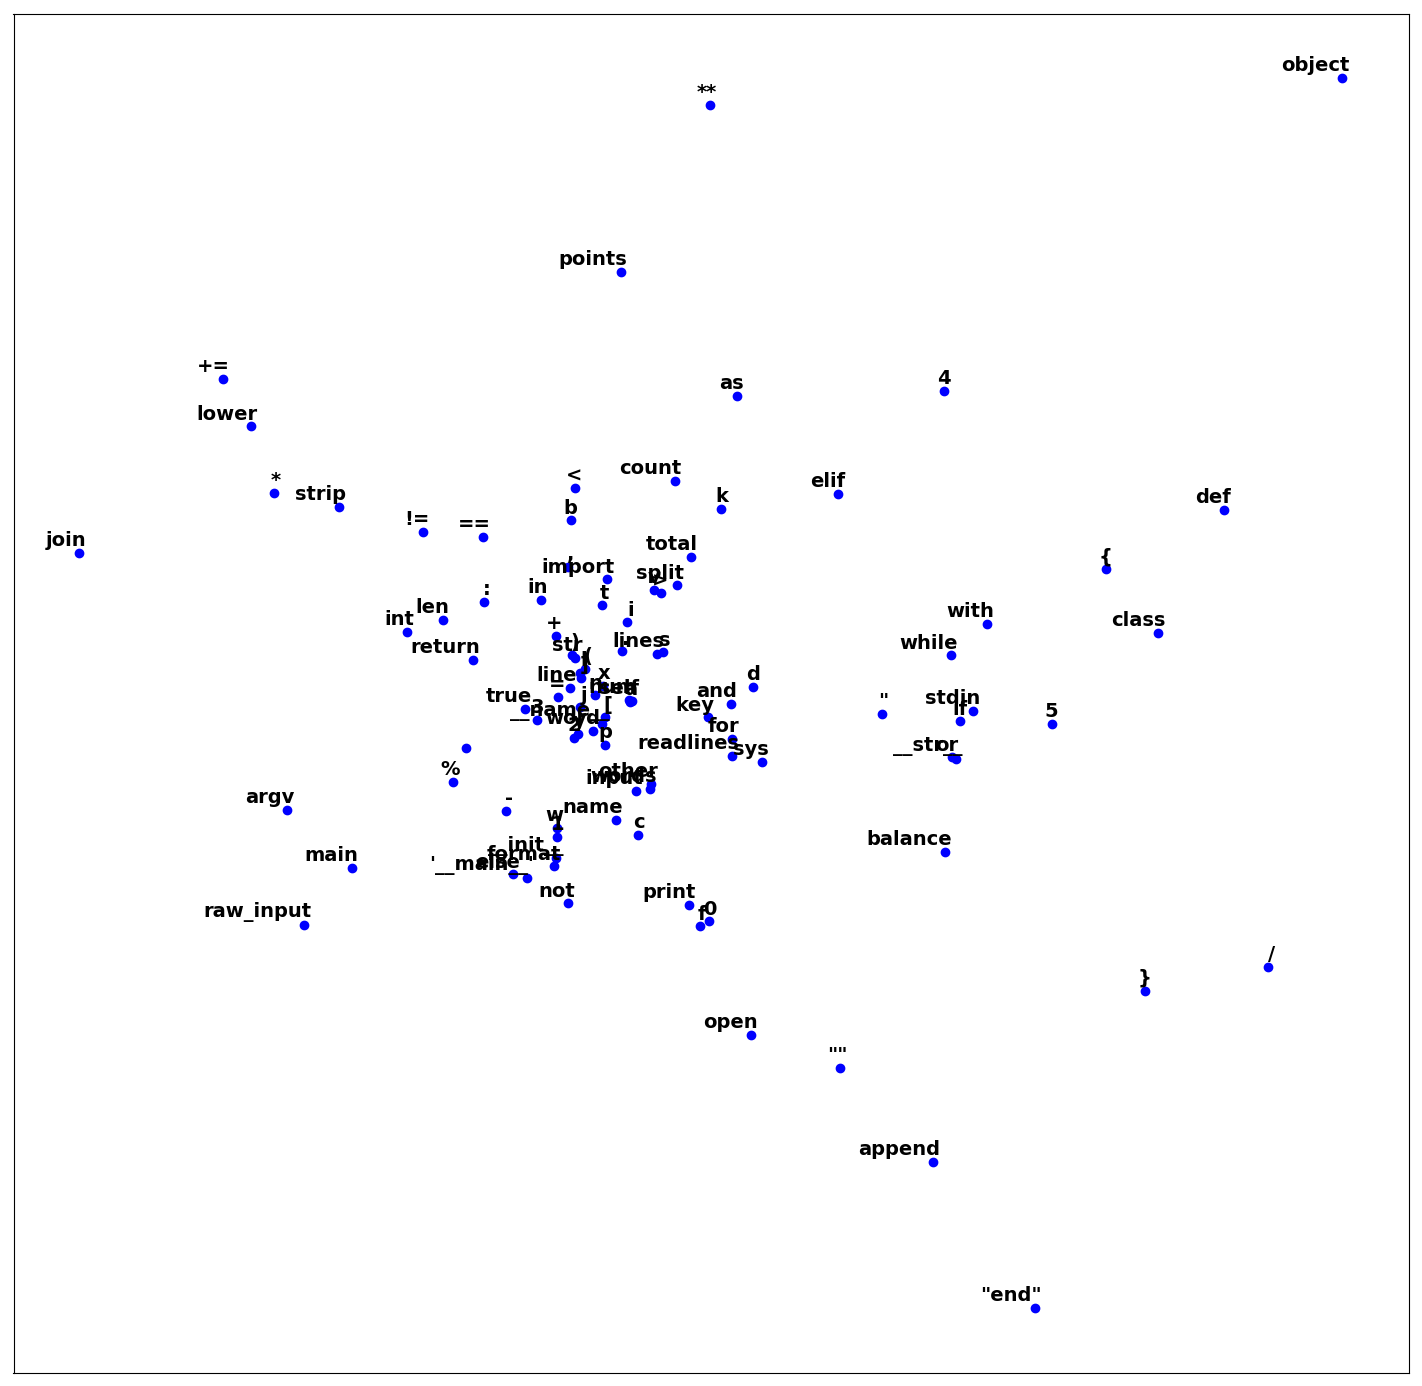

In [166]:
plot_embeddings(token_pca, id_to_token, token_top_words, figsize=(18, 18))

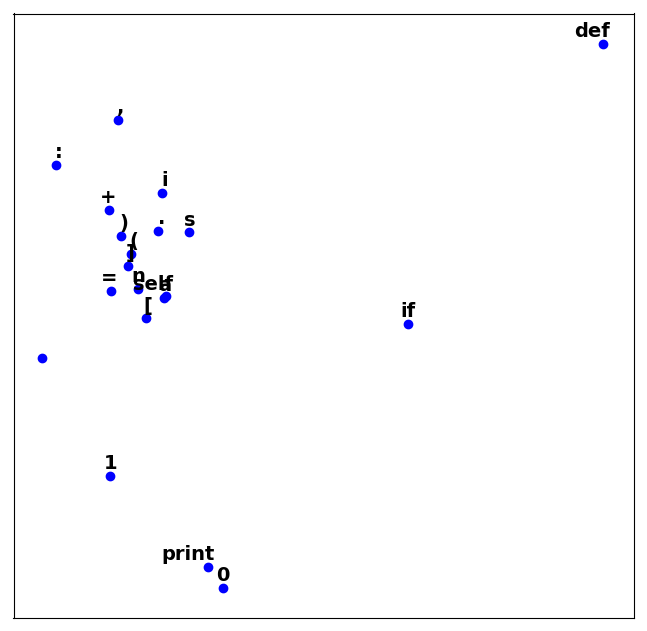

In [167]:
plot_embeddings(token_pca, id_to_token, get_top_words(token_t, 20))

Distances:

In [168]:
get_vector_cosine_distance(token_embeddings, token_t, '<', '>')

0.77854140839502273

In [169]:
get_vector_cosine_distance(token_embeddings, token_t, '+', '-')

0.85475090437678736

In [170]:
get_vector_cosine_distance(token_embeddings, token_t, 'if', 'elif')

0.64291008215940637

In [171]:
get_vector_cosine_distance(token_embeddings, token_t, 'elif', 'else')

1.0823600911808395

In [172]:
get_vector_cosine_distance(token_embeddings, token_t, '}', ']')

0.91936568065650559

In [173]:
# vector('Paris') - vector('France') + vector('Italy') results in a vector that is very close to vector('Rome')
vector = np.add( 
    np.subtract(token_embeddings[token_t.word_index['elif']], token_embeddings[token_t.word_index['else']]),
    token_embeddings[token_t.word_index['}']]
)

print euclidean(token_embeddings[token_t.word_index[']']], 
                vector)        

3.666659832


In [174]:
get_vector_cosine_distance(token_embeddings, token_t, 'for', 'while')

0.69620593862200586

In [175]:
get_vector_cosine_distance(token_embeddings, token_t, '{', '}')

0.50584006107518276

In [176]:
get_vector_cosine_distance(token_embeddings, token_t, '(', ')')

1.2447620443116354

In [177]:
get_vector_cosine_distance(token_embeddings, token_t, '[', ']')

1.0849889949197886

Euclidean:

In [178]:
get_vector_distance(token_embeddings, token_t, '<', '>')

1.534757137298584

In [179]:
get_vector_distance(token_embeddings, token_t, '+', '-')

1.3998416662216187

In [180]:
get_vector_distance(token_embeddings, token_t, '==', '!=')

1.3488528728485107

In [181]:
get_vector_distance(token_embeddings, token_t, 'if', 'elif')

1.7410444021224976

In [182]:
get_vector_distance(token_embeddings, token_t, 'elif', 'else')

2.0594475269317627

In [183]:
get_vector_distance(token_embeddings, token_t, '*', '/')

3.9768710136413574

In [184]:
get_vector_distance(token_embeddings, token_t, 'for', 'while')

1.9083082675933838

In [185]:
get_vector_distance(token_embeddings, token_t, '{', '[')

3.522411584854126

In [186]:
get_vector_cosine_distance(token_embeddings, token_t, '{', '[')

0.93368823999570705

In [187]:
get_vector_distance(token_embeddings, token_t, '}', ']')

2.618786334991455

In [188]:
get_vector_distance(token_embeddings, token_t, '[', ']')

0.9633668065071106

In [189]:
get_vector_distance(token_embeddings, token_t, '(', ')')

0.7993926405906677

Neighbors:

In [190]:
get_neighbors('if', token_embeddings, token_t, id_to_token, top_n=10)

world.\n": 1.56499203156
{:.2f}": 1.5469577546
living.": 1.53960483388
way.": 1.53338241499
'fred': 1.52711713821
e1: 1.52470410092
equal_to: 1.51783570186
matrix: 1.51572986219
"fizz-buzz": 1.51028921552
disc: 1.50703065993


In [191]:
get_neighbors('for', token_embeddings, token_t, id_to_token)

{:.2f}": 1.42655297537
"celcius: 1.42483955764
most_e: 1.41746076567
disc: 1.41075571289
".bak": 1.40596698617


In [192]:
get_neighbors('i', token_embeddings, token_t, id_to_token, top_n=10)

contact': 1.43186671974
ca1_modules: 1.38651571635
aline: 1.37415751496
map: 1.37395444884
>=: 1.37322653048
'fred': 1.36511730443
f_b: 1.36273168013
chars: 1.35878340129
pos_seq: 1.35187227842
t3: 1.34862348837


In [193]:
get_neighbors('print', token_embeddings, token_t, id_to_token, top_n=10)

are.": 1.51590473393
{}\nrace: 1.48507334253
you: 1.46245387328
{},: 1.46207257953
tn: 1.4529310883
total_time: 1.44865831578
bytes': 1.44590228732
'april': 1.4282521054
{:>15.2f}: 1.42398471125
ds: 1.41037797958


In [194]:
get_neighbors('1', token_embeddings, token_t, id_to_token, top_n=20)

house": 1.54669370248
honours: 1.51289972851
grace.": 1.49403032013
'february': 1.44039426312
gross: 1.42965362485
'savings': 1.42935197003
y1: 1.42877339945
"february": 1.42477888284
"may": 1.4211809877
lamp: 1.42029953052
negative: 1.41834624637
represent: 1.40053857932
ending: 1.39726568198
"four": 1.39567882418
runner: 1.39249450508
integers: 1.3896231202
9.25: 1.38075481928
size: 1.3797197932
stack_092: 1.37945685676
search: 1.37873574721


### 2.2) Token categories

In [195]:
'Number encoded docs: {:,}'.format(len(token_ids))

'Number encoded docs: 472,087'

In [196]:
token_ids = [
    ' '.join([str(a) for a in array]) for array in token_ids
]

In [197]:
category_t = get_tokenizer()

category_t.fit_on_texts(token_ids)

In [199]:
category_sequences = category_t.texts_to_sequences(token_ids)

id_to_category = { v: k for k, v in category_t.word_index.items() } # GET THE NAMES here for each category number?

category_padded_docs = pad_sequences(category_sequences, maxlen=MAX_LENGTH, padding='post')

In [200]:
X_train, X_test, y_train, y_test = train_test_split(category_padded_docs, token_labels, test_size=0.2, random_state=0)

In [201]:
category_model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 100)           200000    
_________________________________________________________________
flatten_10 (Flatten)         (None, 5000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 5001      
Total params: 205,001
Trainable params: 205,001
Non-trainable params: 0
_________________________________________________________________
None


In [202]:
category_model.fit(X_train, 
                   y_train,
                   epochs=10,
                   validation_split=0.2)

Train on 302135 samples, validate on 75534 samples
Epoch 1/10
302135/302135 [==============================] - 60s 197us/step - loss: 0.6641 - acc: 0.6043 - f1: 0.2275 - val_loss: 0.6643 - val_acc: 0.6045 - val_f1: 0.3340
Epoch 2/10
302135/302135 [==============================] - 58s 193us/step - loss: 0.6616 - acc: 0.6065 - f1: 0.2586 - val_loss: 0.6633 - val_acc: 0.6056 - val_f1: 0.1425
Epoch 3/10
302135/302135 [==============================] - 60s 198us/step - loss: 0.6609 - acc: 0.6071 - f1: 0.2629 - val_loss: 0.6601 - val_acc: 0.6076 - val_f1: 0.2370
Epoch 4/10
302135/302135 [==============================] - 60s 197us/step - loss: 0.6603 - acc: 0.6083 - f1: 0.2665 - val_loss: 0.6597 - val_acc: 0.6055 - val_f1: 0.2572
Epoch 5/10
302135/302135 [==============================] - 62s 206us/step - loss: 0.6601 - acc: 0.6076 - f1: 0.2671 - val_loss: 0.6596 - val_acc: 0.6108 - val_f1: 0.2795
Epoch 6/10
302135/302135 [==============================] - 62s 206us/step - loss: 0.6597 - ac

In [204]:
cat_loss, cat_accuracy, cat_f1 = category_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f, F1: %f' % (token_accuracy * 100, cat_f1 * 100))

94418/94418 [==============================] - 5s 56us/step
Accuracy: 74.930628, F1: 19.645448


In [205]:
category_score = {
    'accuracy': cat_accuracy,
    'F1': cat_f1,
}
embeddings_scores['Category Token'] = category_score

In [206]:
category_embeddings = get_embeddings(category_model)

category_embeddings[0]

Embedding Layer shape: (2000, 100)


array([ -8.18085391e-03,   2.24015093e-03,  -8.37654900e-03,
        -5.50646707e-03,   4.89879027e-03,   1.32837556e-02,
         1.63092429e-03,  -9.28424206e-03,   3.57299601e-03,
        -4.07622196e-03,   6.05876278e-03,   1.14216213e-03,
         3.60442442e-03,  -1.95775833e-03,   1.69958384e-03,
        -3.36261690e-02,  -1.14982650e-02,  -1.86065193e-02,
        -3.97191988e-03,  -9.91913024e-03,   1.80185866e-03,
         1.71504985e-03,   1.72294700e-03,  -9.31200106e-04,
         1.13896746e-03,   7.04176165e-03,   3.12622404e-04,
         7.15604750e-04,  -5.08969650e-03,  -2.02219225e-02,
        -3.11495084e-03,  -2.02032737e-03,  -1.16897374e-02,
        -8.18699412e-03,   1.29963672e-02,  -3.02376831e-03,
         1.04455287e-02,   4.00674157e-03,  -1.61459725e-02,
         1.82588818e-03,   6.60891458e-03,   2.77876854e-03,
        -6.66894438e-03,  -6.77065982e-04,   7.21814530e-03,
         3.32226686e-04,   2.33388692e-03,   7.63606234e-03,
         1.76816841e-03,

In [207]:
# np.save('data/processed/token_category_embeddings', category_embeddings)

In [208]:
category_pca = get_pca(category_embeddings)

PCA explained variance ratio: [ 0.35952729  0.02282144] Total: 0.382348729298


In [209]:
category_top_words = get_top_words(category_t, N=100)

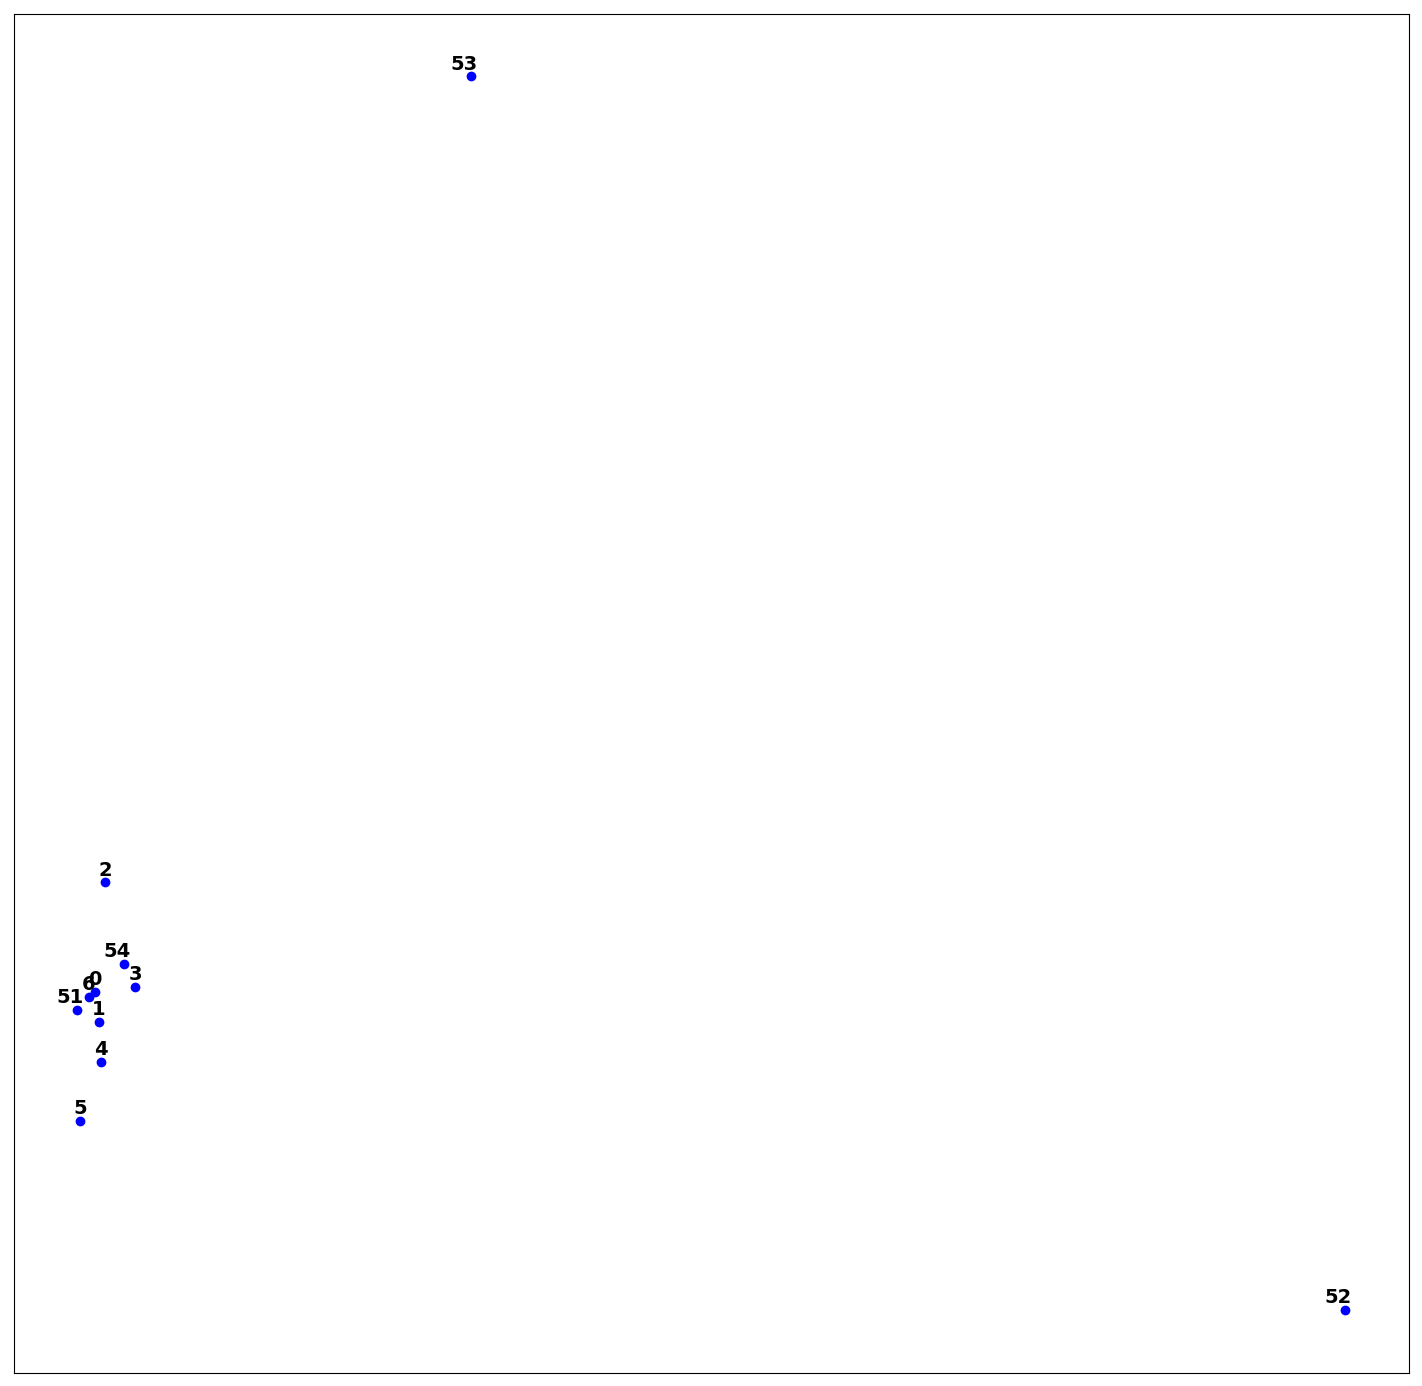

In [210]:
plot_embeddings(category_pca, id_to_category, category_top_words, figsize=(18, 18))

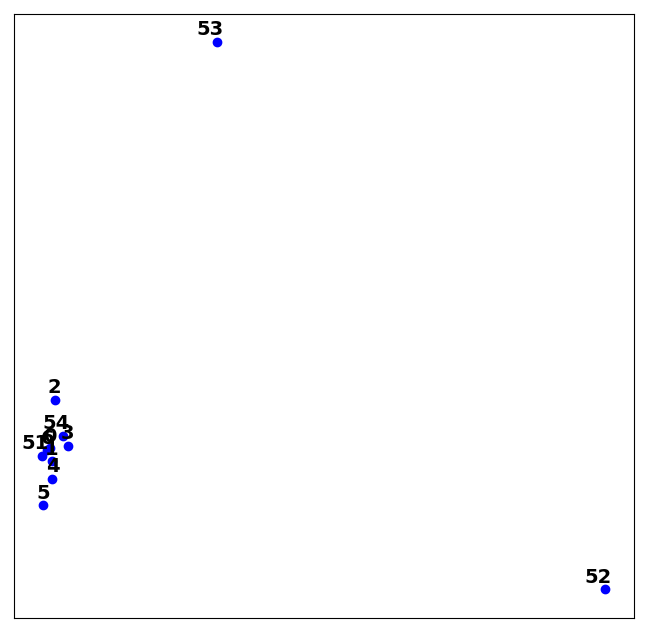

In [211]:
plot_embeddings(category_pca, id_to_category, get_top_words(category_t, 20))

In [212]:
categories = [
('ENDMARKER', 0),
('NAME', 1),
('NUMBER', 2),
('STRING', 3),
('NEWLINE', 4),
('INDENT', 5),
('DEDENT', 6),
('LPAR', 7),
('RPAR', 8),
('LSQB', 9),
('RSQB', 10),
('COLON', 11),
('COMMA', 12),
('SEMI', 13),
('PLUS', 14),
('MINUS', 15),
('STAR', 16),
('SLASH', 17),
('VBAR', 18),
('AMPER', 19),
('LESS', 20),
('GREATER', 21),
('EQUAL', 22),
('DOT', 23),
('PERCENT', 24),
('LBRACE', 25),
('RBRACE', 26),
('EQEQUAL', 27),
('NOTEQUAL', 28),
('LESSEQUAL', 29),
('GREATEREQUAL', 30),
('TILDE', 31),
('CIRCUMFLEX', 32),
('LEFTSHIFT', 33),
('RIGHTSHIFT', 34),
('DOUBLESTAR', 35),
('PLUSEQUAL', 36),
('MINEQUAL', 37),
('STAREQUAL', 38),
('SLASHEQUAL', 39),
('PERCENTEQUAL', 40),
('AMPEREQUAL', 41),
('VBAREQUAL', 42),
('CIRCUMFLEXEQUAL', 43),
('LEFTSHIFTEQUAL', 44),
('RIGHTSHIFTEQUAL', 45),
('DOUBLESTAREQUAL', 46),
('DOUBLESLASH', 47),
('DOUBLESLASHEQUAL', 48),
('AT', 49),
('ATEQUAL', 50),
('RARROW', 51),
('ELLIPSIS', 52),
('OP', 53),
('ERRORTOKEN', 54),
('COMMENT', 55),
('NL', 56),
('ENCODING', 57),
('N_TOKENS', 58),
]

In [213]:
category_names = { c[1]: c[0] for c in categories }

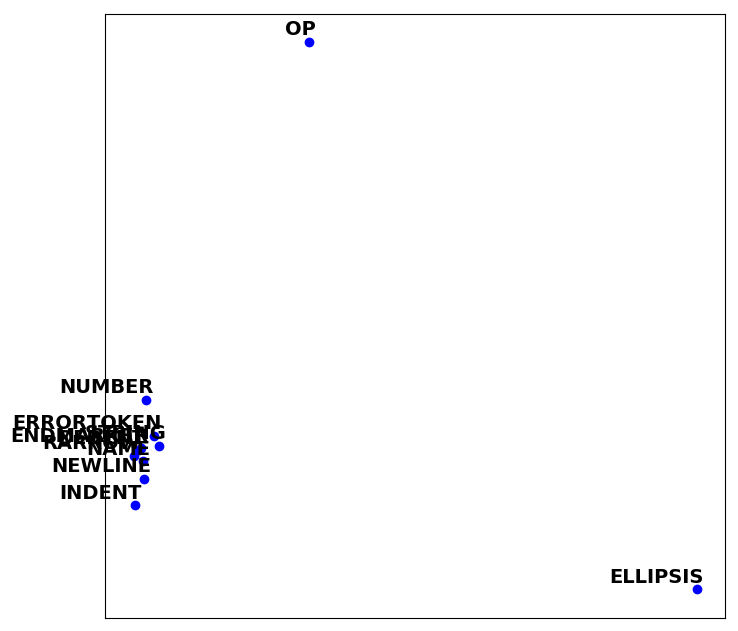

In [220]:
top_20_words = get_top_words(category_t, 20)

plt.figure(figsize=(8, 8), dpi=100)
ax = plt.axes()
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
i = 0
while i < len(category_pca):

    if i in id_to_word and i in id_to_category:

        x, y = category_pca[i, :]
        word = id_to_category[i]

        if word in top_20_words:
            label = category_names[int(word)]
            plt.scatter(x, y, color='b')
            plt.annotate(label,
                        xy=(x, y),
                        xytext=(5, 2),
                        textcoords='offset points',
                        ha='right',
                        va='bottom',
                        fontsize=14)
    i += 1

## 3) Programs as Abstract Syntax Trees

In [124]:
# TODO

Store scorings:

In [217]:
embeddings_scores

{'Category Token': {'F1': 0.19645448217258843,
  'accuracy': 0.61006375903278642},
 'Word': {'accuracy': 0.73248848865407301, 'f1': 0.6410933540918673},
 'Word Token': {'F1': 0.67186247301242086, 'accuracy': 0.74930627634308689}}

In [218]:
import json
with open('data/processed/embeddings_scores.json', 'w') as outfile:
    json.dump(embeddings_scores, outfile)

Store tokenizers:

In [221]:
import pickle
with open('word_tokenizer.pickle', 'wb') as handle:
    pickle.dump(word_t, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [222]:
with open('token_tokenizer.pickle', 'wb') as handle:
    pickle.dump(token_t, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [223]:
with open('category_tokenizer.pickle', 'wb') as handle:
    pickle.dump(category_t, handle, protocol=pickle.HIGHEST_PROTOCOL)